In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd


/home/nwoofter/sipm-analysis


## Example waveforms

In [4]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/*/'
glob.glob(data_dir)

['/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1120/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_60_light_laser_config_1_cond_ln_long_intensity_500/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_92_light_laser_config_1_cond_ln_intensity_1020/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1020/',
 '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_92_light_laser_config_1_cond_ln_intensity_1120/']

/scratch/gpfs/GALBIATI/data/sipm//hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1120/wave0.dat
51129 events


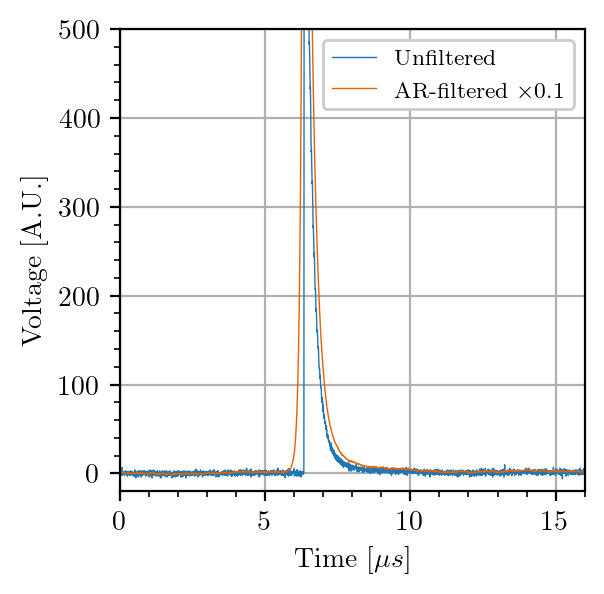

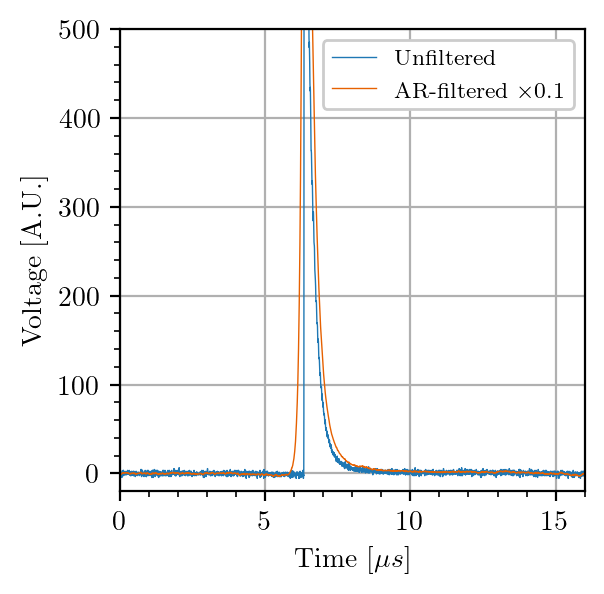

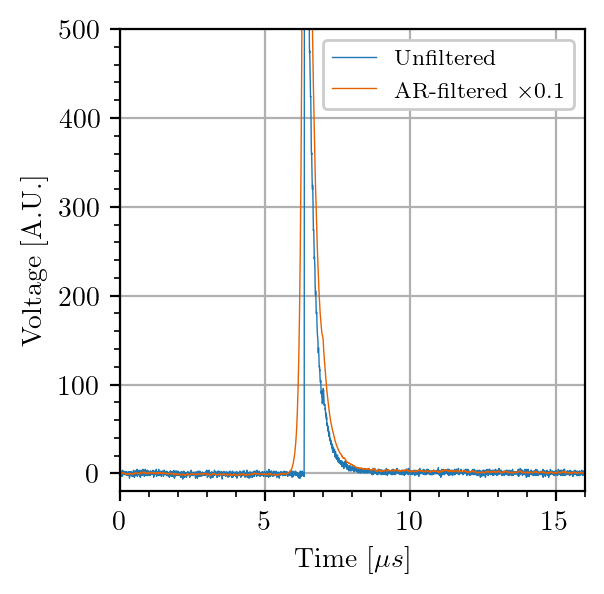

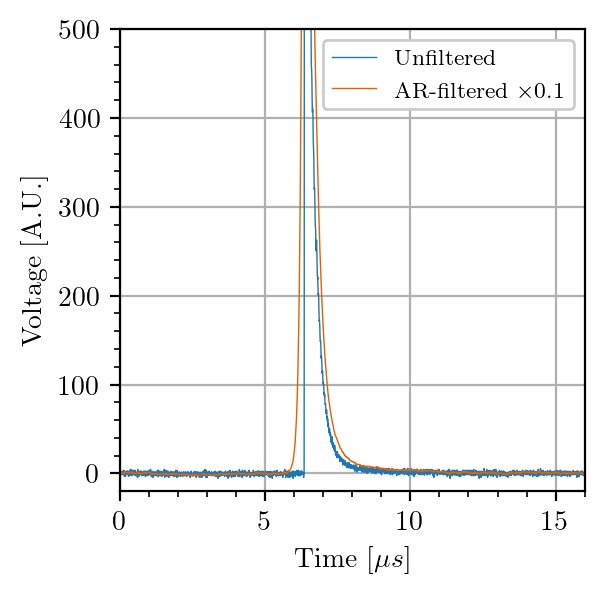

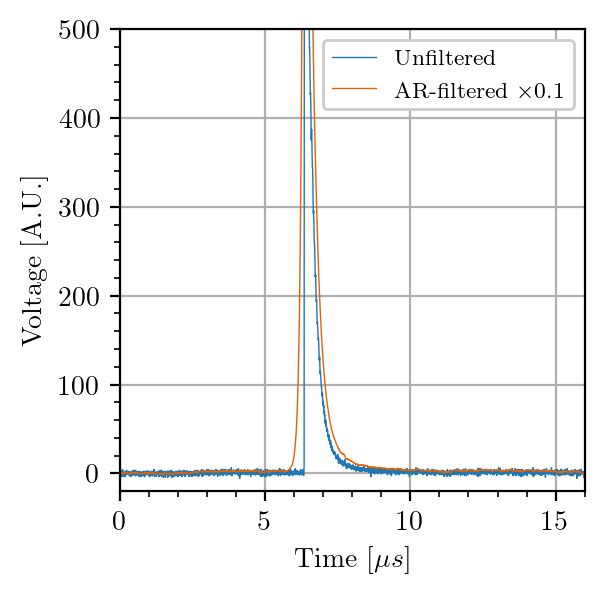

In [5]:
import sipm.recon.WaveformDataset as wfd
ch = 0
evid = np.arange(5, 10)
dset = wfd.WaveformDataset(path='/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1120/', pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-20, 500)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [7]:
# data folder
path = "/scratch/gpfs/nwoofter/results/"
data = {}
intensity = [1020, 1120]
channels = [0, 1, 2, 3]
voltages = [90,92]
for intn in intensity:
    data[intn] = {}
    for ch in channels:
        data[intn][ch] = {}
        for volt in voltages:
            data[intn][ch][volt] = []
            files = glob.glob(f"{path}2023-06-07/*volt_{volt}*intensity_{intn}*[!_wf].h5")
            print(files)
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[intn][ch][volt].append(df)
            data[intn][ch][volt] = pd.concat(
                data[intn][ch][volt], ignore_index=True)
print('keys: ', list(data[1020][0][90].keys()))

['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0.h5']
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_92_light_laser_c

In [8]:
intn = 1020
ch = 0
volt = 90
data[intn][ch][volt]

,baseline_mean,baseline_rms,amplitude_trig,peakpos_trig,integral_5p00us
0,3835.932469,1.717480,374.117879,1588,2056.911323
1,3835.933834,1.715546,366.615285,1587,1405.630286
2,3835.491132,1.630286,385.495052,1587,1612.826739
3,3835.366985,1.618987,427.285934,1586,1049.401091
4,3834.612551,1.785176,746.108748,1589,3761.814461
...,...,...,...,...,...
50794,3835.743520,1.668168,367.198541,1589,1194.834925
50795,3836.272851,1.725908,781.678605,1587,2585.792633
50796,3836.598909,1.968746,697.647699,1590,3946.624829
50797,3834.684857,1.612199,375.874031,1587,869.919509


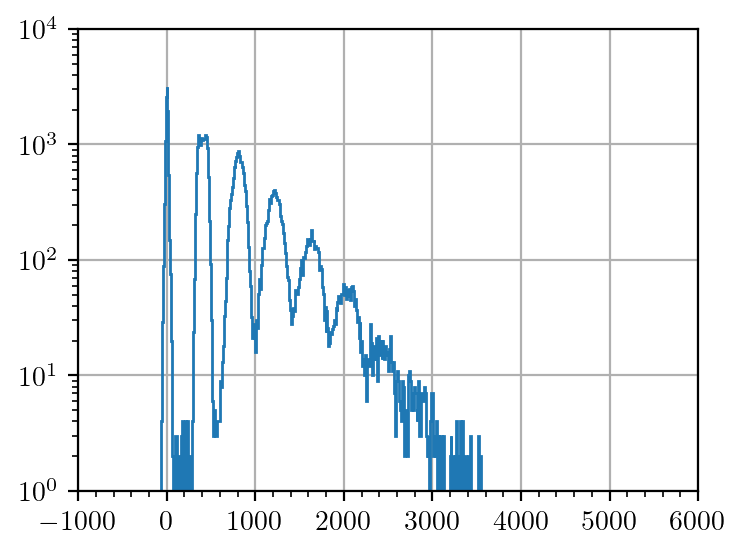

In [9]:
intn = 1020
ch = 0
volt = 90
plt.hist(data[intn][ch][volt]['amplitude_trig'], bins=500, histtype='step')
plt.minorticks_on()
plt.grid()
plt.yscale('log')